# Photonic Dirac Point Search for Bistritzer-MacDonald Model

This notebook implements the first step of the photonic Bistritzer-MacDonald model:
Finding a hexagonal photonic crystal lattice with air holes that exhibits a Dirac point at the K point of the Brillouin zone.

We will:
1. Set up a hexagonal lattice with circular air holes
2. Vary the background dielectric constant and hole radius
3. Use MPB (MIT Photonic Bands) to compute band structures
4. Search for parameters that give a good Dirac point (linear band touching)
5. Visualize the results

## Theory Background

From the theoretical description, we need to find parameters where two bands touch linearly at the K point, creating an accidental degeneracy that can be approximated as:

$$H_{ph}^{(0)}(-i\nabla) \approx v_{ph}(\sigma_x q_x + \sigma_y q_y)$$

where $v_{ph}$ is the photonic "Dirac velocity" at the K point.

In [1]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
from scipy.interpolate import interp1d
import os
import tempfile
import shutil
from pathlib import Path
from rich.console import Console
from rich.progress import Progress, SpinnerColumn, TextColumn, BarColumn, TaskProgressColumn
from rich.table import Table
from rich.panel import Panel
import time
import json

# Meep and electromagnetic simulation
import meep as mp
from meep import mpb
import h5py

# Set up vintage color palette for dark mode
plt.style.use('dark_background')
VINTAGE_COLORS = {
    'bright_orange': '#FF6B35',  # Bright orange
    'electric_blue': '#004CFF',  # Electric blue  
    'lime_green': '#32CD32',     # Lime green
    'hot_pink': '#FF1493',       # Hot pink
    'gold': '#FFD700',           # Gold
    'cyan': '#00FFFF',           # Cyan
    'coral': '#FF7F50',          # Coral
    'violet': '#8A2BE2',         # Blue violet
    'yellow': '#FFFF00',         # Bright yellow
    'spring_green': '#00FF7F'    # Spring green
}

# Set matplotlib defaults for better dark mode visibility
plt.rcParams.update({
    'figure.facecolor': '#1e1e1e',
    'axes.facecolor': '#2d2d2d', 
    'axes.edgecolor': '#ffffff',
    'axes.labelcolor': '#ffffff',
    'text.color': '#ffffff',
    'xtick.color': '#ffffff',
    'ytick.color': '#ffffff',
    'grid.color': '#555555',
    'font.size': 11,
    'axes.titlesize': 13,
    'axes.labelsize': 11
})

# Set up rich console for beautiful output
console = Console()
console.print("[bold green]Photonic Dirac Point Search with Meep Initialized[/bold green]")

Photonic Dirac Point Search with Meep Initialized

In [2]:
# Configuration and parameters
class PhotonicCrystalConfig:
    def __init__(self):
        # Lattice parameters
        self.lattice_constant = 1.0  # Normalized to 1
        self.num_bands = 8  # Number of bands to compute
        self.resolution = 32  # Grid resolution
        
        # Search parameters
        self.epsilon_bg_range = (2.0, 13.0)  # Background dielectric range
        self.radius_range = (0.1, 0.49)  # Hole radius range (fraction of lattice constant)
        self.num_epsilon_points = 15
        self.num_radius_points = 15
        
        # K-point in reduced coordinates (corner of hexagonal BZ)
        self.k_point = np.array([1/3, 1/3, 0])  # K point in hexagonal BZ
        
        # Criteria for good Dirac point
        self.max_gap_threshold = 0.01  # Maximum allowed gap at K point
        self.min_slope_threshold = 0.1  # Minimum slope for linear dispersion

config = PhotonicCrystalConfig()
console.print(f"[blue]Configuration loaded:[/blue]")
console.print(f"  Background ε range: {config.epsilon_bg_range}")
console.print(f"  Radius range: {config.radius_range}")
console.print(f"  Search grid: {config.num_epsilon_points} × {config.num_radius_points}")

Configuration loaded:

Background ε range: (2.0, 13.0)

Radius range: (0.1, 0.49)

Search grid: 15 × 15

In [11]:
# MPB interface functions for photonic band structure calculations
def create_hexagonal_lattice_geometry(epsilon_bg, radius, lattice_constant=1.0):
    """
    Create a hexagonal lattice geometry using MPB.
    Returns the geometry list and lattice specification.
    """
    # Create geometry: air hole in dielectric background
    geometry = [
        mp.Cylinder(
            center=mp.Vector3(0, 0, 0),  # Center at origin in fractional coordinates
            radius=radius,
            height=mp.inf,
            material=mp.Medium(epsilon=1.0)  # Air hole
        )
    ]
    
    # Hexagonal lattice specification - following working example
    geometry_lattice = mp.Lattice(
        size=mp.Vector3(1, 1, 0),
        basis1=mp.Vector3(lattice_constant, 0, 0),
        basis2=mp.Vector3(lattice_constant * 0.5, lattice_constant * np.sqrt(3) * 0.5, 0)
    )
    
    # Background material
    default_material = mp.Medium(epsilon=epsilon_bg)
    
    return geometry, geometry_lattice, default_material

def calculate_k_point_frequencies_with_progress(epsilon_bg, radius, resolution=32, num_bands=8, progress_callback=None):
    """
    Calculate frequencies only at K point with detailed progress tracking.
    """
    import io
    import sys
    from contextlib import redirect_stdout, redirect_stderr
    
    try:
        if progress_callback:
            progress_callback("Creating geometry...")
        
        # Create geometry
        geometry, geometry_lattice, default_material = create_hexagonal_lattice_geometry(
            epsilon_bg, radius, 1.0
        )
        
        if progress_callback:
            progress_callback("Initializing MPB solver...")
        
        # Create temporary directory for MPB output
        import tempfile
        with tempfile.TemporaryDirectory() as tmpdir:
            old_cwd = os.getcwd()
            os.chdir(tmpdir)
            
            try:
                # Create ModeSolver
                ms = mpb.ModeSolver(
                    geometry=geometry,
                    geometry_lattice=geometry_lattice,
                    resolution=resolution,
                    num_bands=num_bands,
                    default_material=default_material
                )
                
                if progress_callback:
                    progress_callback("Setting up K point...")
                
                # K point in fractional coordinates for hexagonal lattice
                K_point = mp.Vector3(1/3, 1/3, 0)
                
                if progress_callback:
                    progress_callback("Running TE solver...")
                
                # Capture output to avoid clutter
                output_buffer = io.StringIO()
                with redirect_stdout(output_buffer):
                    # Run TE calculation only at K point
                    ms.run_te([K_point])
                
                if progress_callback:
                    progress_callback("Extracting frequencies...")
                
                # Get frequencies
                k_point_freqs = ms.get_freqs()
                
                # Check output for errors
                output = output_buffer.getvalue()
                if "error" in output.lower():
                    console.print(f"[yellow]MPB warning: {output[:200]}...[/yellow]")
                
                return np.array(k_point_freqs)
                
            finally:
                os.chdir(old_cwd)
        
    except Exception as e:
        if progress_callback:
            progress_callback(f"Failed: {str(e)}")
        console.print(f"[red]MPB K-point calculation failed: {str(e)}[/red]")
        import traceback
        traceback.print_exc()
        return None

def calculate_k_point_frequencies(epsilon_bg, radius, resolution=32, num_bands=8):
    """
    Wrapper for backward compatibility.
    """
    return calculate_k_point_frequencies_with_progress(epsilon_bg, radius, resolution, num_bands)

def calculate_band_structure_with_mpb(epsilon_bg, radius, work_dir=None):
    """
    Calculate band structure using MPB eigenmode solver.
    Simplified version that only calculates at K point for speed.
    """
    if work_dir is None:
        work_dir = tempfile.mkdtemp()
    
    # Change to working directory for MPB output files
    old_cwd = os.getcwd()
    
    try:
        os.chdir(work_dir)
        
        # Just get K-point frequencies
        k_point_freqs = calculate_k_point_frequencies(epsilon_bg, radius)
        
        return None, k_point_freqs  # No full band structure needed for search
    
    finally:
        # Always return to original directory
        os.chdir(old_cwd)
        # Clean up temporary files
        if os.path.exists(work_dir):
            shutil.rmtree(work_dir, ignore_errors=True)

def extract_frequencies_near_k_point(epsilon_bg, radius, k_resolution=5):
    """
    Extract frequencies in a small region around the K point for Dirac velocity estimation.
    """
    try:
        # Create geometry
        geometry, geometry_lattice, default_material = create_hexagonal_lattice_geometry(epsilon_bg, radius)
        
        # Create ModeSolver
        ms = mpb.ModeSolver(
            geometry=geometry,
            geometry_lattice=geometry_lattice,
            resolution=64,  # Higher resolution for accuracy
            num_bands=config.num_bands,
            default_material=default_material
        )
        
        k_base = mp.Vector3(1/3, 1/3, 0)
        delta_k = 0.02  # Small perturbation around K point
        
        k_points_near_k = []
        frequencies_near_k = []
        
        # Sample points around K point
        for i in range(-k_resolution//2, k_resolution//2 + 1):
            for j in range(-k_resolution//2, k_resolution//2 + 1):
                if i == 0 and j == 0:
                    continue  # Skip the exact K point
                dk = mp.Vector3(i * delta_k / k_resolution, j * delta_k / k_resolution, 0)
                k_point = k_base + dk
                k_points_near_k.append(k_point)
                
                # Calculate frequencies at this k-point
                ms.run_te([k_point])
                freqs = ms.get_freqs()
                frequencies_near_k.append(freqs.copy())
        
        return k_points_near_k, frequencies_near_k
        
    except Exception as e:
        console.print(f"[red]K-point sampling failed: {str(e)}[/red]")
        return [], []

console.print("[green]MPB interface functions defined[/green]")

MPB interface functions defined

In [12]:
# Main search algorithm using scipy optimization with enhanced progress
def dirac_point_objective_with_progress(params, return_details=False, progress_info=None):
    """
    Objective function for scipy optimization with progress tracking.
    Minimizes the band gap at K point to find Dirac points.
    """
    epsilon_bg, radius = params
    
    # Bounds check
    if not (config.epsilon_bg_range[0] <= epsilon_bg <= config.epsilon_bg_range[1]):
        if return_details:
            return 1e6, None
        return 1e6
    if not (config.radius_range[0] <= radius <= config.radius_range[1]):
        if return_details:
            return 1e6, None
        return 1e6
    
    # Progress callback
    def mpb_progress(msg):
        if progress_info and 'callback' in progress_info:
            progress_info['callback'](f"ε={epsilon_bg:.1f}, r={radius:.2f}: {msg}")
    
    # Calculate frequencies at K point with progress
    freqs = calculate_k_point_frequencies_with_progress(
        epsilon_bg, radius, 
        resolution=24, 
        num_bands=6,
        progress_callback=mpb_progress
    )
    
    if freqs is None or len(freqs) < 4:
        if return_details:
            return 1e6, None
        return 1e6
    
    # Debug: print frequencies for first few calculations
    if hasattr(dirac_point_objective_with_progress, 'call_count'):
        dirac_point_objective_with_progress.call_count += 1
    else:
        dirac_point_objective_with_progress.call_count = 1
    
    if dirac_point_objective_with_progress.call_count <= 5:
        console.print(f"[dim]Debug: ε={epsilon_bg:.1f}, r={radius:.2f}, freqs={freqs}[/dim]")
    
    # Find smallest gap between consecutive bands
    gaps = []
    for i in range(len(freqs) - 1):
        if freqs[i] > 0.01:  # Ignore very low frequencies (usually spurious)
            gap = freqs[i+1] - freqs[i]
            gaps.append(gap)
    
    min_gap = min(gaps) if gaps else 1e6
    
    # Also check for Dirac point characteristics
    # Look for bands 2 and 3 (or 3 and 4) being close
    dirac_gap = None
    dirac_freq = None
    if len(freqs) >= 4:
        # Check gap between bands 2-3 (indices 1-2)
        gap_23 = freqs[2] - freqs[1] if freqs[1] > 0.01 else 1e6
        # Check gap between bands 3-4 (indices 2-3)
        gap_34 = freqs[3] - freqs[2] if freqs[2] > 0.01 else 1e6
        
        # Use the smaller gap
        if gap_23 < gap_34:
            dirac_gap = gap_23
            dirac_freq = (freqs[1] + freqs[2]) / 2
        else:
            dirac_gap = gap_34
            dirac_freq = (freqs[2] + freqs[3]) / 2
        
        # Override min_gap with dirac_gap if it's reasonable
        if dirac_gap < 0.1:  # Only consider gaps < 0.1 as potential Dirac points
            min_gap = dirac_gap
    
    if return_details:
        return min_gap, freqs
    return min_gap

def dirac_point_objective(params, return_details=False):
    """Original objective function for compatibility"""
    return dirac_point_objective_with_progress(params, return_details, None)

def grid_search_dirac_parameters():
    """
    Coarse grid search with enhanced progress tracking.
    """
    from rich.progress import Progress, SpinnerColumn, BarColumn, TextColumn, TimeRemainingColumn
    from rich.table import Table
    from rich.live import Live
    from rich.layout import Layout
    from rich.panel import Panel
    import time
    
    console.print("[blue]Running coarse grid search with detailed progress...[/blue]")
    
    # Coarse grid - use fewer points for faster testing
    eps_coarse = np.linspace(*config.epsilon_bg_range, 6)  # Reduced from 8
    r_coarse = np.linspace(*config.radius_range, 6)  # Reduced from 8
    
    best_params = None
    best_gap = float('inf')
    current_status = {
        'current_eps': 0,
        'current_r': 0,
        'mpb_status': 'Waiting...',
        'calculations_done': 0,
        'best_gap': float('inf'),
        'best_params': None,
        'valid_results': 0
    }
    
    total_calcs = len(eps_coarse) * len(r_coarse)
    
    def create_progress_display():
        # Create main progress bar
        progress_text = f"Grid Search Progress: {current_status['calculations_done']}/{total_calcs} "
        progress_text += f"({100*current_status['calculations_done']/total_calcs:.1f}%)\n"
        
        # Create progress bar visual
        progress_bar = "█" * int(40 * current_status['calculations_done'] / total_calcs)
        progress_bar += "░" * (40 - len(progress_bar))
        
        # Current calculation info
        calc_info = f"\nCurrent: ε={current_status['current_eps']:.2f}, r={current_status['current_r']:.3f}\n"
        calc_info += f"MPB Status: {current_status['mpb_status']}\n"
        calc_info += f"Valid results found: {current_status['valid_results']}\n"
        
        # Best result
        if current_status['best_params'] and current_status['best_gap'] < 1e5:
            best_info = f"\nBest so far: ε={current_status['best_params'][0]:.2f}, "
            best_info += f"r={current_status['best_params'][1]:.3f}, gap={current_status['best_gap']:.5f}"
        else:
            best_info = "\nNo valid results yet..."
        
        panel_content = f"{progress_text}[green]{progress_bar}[/green]{calc_info}{best_info}"
        
        return Panel(panel_content, title="[bold]Grid Search Progress[/bold]", border_style="blue")
    
    with Live(create_progress_display(), refresh_per_second=10, console=console) as live:
        start_time = time.time()
        
        for i, eps in enumerate(eps_coarse):
            for j, r in enumerate(r_coarse):
                current_status['current_eps'] = eps
                current_status['current_r'] = r
                current_status['mpb_status'] = 'Starting MPB...'
                live.update(create_progress_display())
                
                # Progress callback for MPB
                def update_mpb_status(msg):
                    current_status['mpb_status'] = msg
                    live.update(create_progress_display())
                
                progress_info = {'callback': update_mpb_status}
                
                # Run calculation with progress
                gap = dirac_point_objective_with_progress([eps, r], progress_info=progress_info)
                
                current_status['calculations_done'] += 1
                
                if gap < 1e5:  # Valid result
                    current_status['valid_results'] += 1
                    if gap < best_gap:
                        best_gap = gap
                        best_params = (eps, r)
                        current_status['best_gap'] = best_gap
                        current_status['best_params'] = best_params
                        current_status['mpb_status'] = f'New best! Gap = {gap:.5f}'
                    else:
                        current_status['mpb_status'] = f'Complete (gap = {gap:.5f})'
                else:
                    current_status['mpb_status'] = 'Failed or invalid result'
                
                live.update(create_progress_display())
                
                # Small delay to show progress
                time.sleep(0.05)
        
        elapsed = time.time() - start_time
        current_status['mpb_status'] = f'Grid search complete in {elapsed:.1f}s'
        live.update(create_progress_display())
        time.sleep(1)
    
    if best_params:
        console.print(f"[green]Grid search found: ε={best_params[0]:.1f}, r={best_params[1]:.2f}, gap={best_gap:.4f}[/green]")
    else:
        console.print("[yellow]Grid search found no valid parameters. Using literature values.[/yellow]")
        # Use known good parameters from literature
        best_params = (11.56, 0.30)  # Silicon-like parameters known to have Dirac points
    
    return best_params

def search_dirac_parameters():
    """
    Search for Dirac points using scipy optimization with comprehensive progress.
    """
    from scipy.optimize import minimize, differential_evolution
    from rich.live import Live
    from rich.panel import Panel
    from rich.table import Table
    import time
    import threading
    
    console.print("[bold blue]Starting Dirac Point Search with Enhanced Progress Tracking[/bold blue]")
    
    # First, test if MPB is working at all
    console.print("[yellow]Testing MPB solver...[/yellow]")
    test_freqs = calculate_k_point_frequencies(11.0, 0.3, resolution=16, num_bands=4)
    if test_freqs is None:
        console.print("[red]MPB test failed! Check your MPB installation.[/red]")
        return [], np.array([]), np.array([])
    else:
        console.print(f"[green]MPB test successful! Got {len(test_freqs)} frequencies.[/green]")
    
    # Find good starting point with coarse grid
    start_params = grid_search_dirac_parameters()
    
    console.print(f"[yellow]Starting optimization from ε={start_params[0]:.1f}, r={start_params[1]:.2f}[/yellow]")
    
    # Track optimization progress
    iteration_data = {
        'iteration': 0,
        'best_gap': float('inf'),
        'best_params': start_params,
        'current_params': start_params,
        'function_calls': 0,
        'status': 'Initializing...',
        'mpb_status': '',
        'optimizer': 'Grid Search'
    }
    
    top_results = []
    
    def create_status_panel():
        status_text = f"""[bold cyan]Optimization Status[/bold cyan]
        
Optimizer: {iteration_data['optimizer']}
Iteration: {iteration_data['iteration']}
Function Calls: {iteration_data['function_calls']}
Status: {iteration_data['status']}
MPB: {iteration_data['mpb_status']}

[bold]Current Parameters:[/bold]
  ε = {iteration_data['current_params'][0]:.3f}
  r = {iteration_data['current_params'][1]:.3f}

[bold]Best Result:[/bold]
  ε = {iteration_data['best_params'][0]:.3f}
  r = {iteration_data['best_params'][1]:.3f}
  Gap = {iteration_data['best_gap']:.5f}
"""
        return Panel(status_text, title="[bold]Dirac Point Search Progress[/bold]", border_style="blue")
    
    # Callback with MPB progress
    def callback_with_progress(xk, convergence=None):
        """Enhanced callback with MPB progress tracking"""
        iteration_data['iteration'] += 1
        iteration_data['current_params'] = xk
        iteration_data['function_calls'] += 1
        
        # Progress callback for MPB
        def update_mpb(msg):
            iteration_data['mpb_status'] = msg
        
        progress_info = {'callback': update_mpb}
        
        # Evaluate current point with progress
        gap, freqs = dirac_point_objective_with_progress(xk, return_details=True, progress_info=progress_info)
        
        if gap < iteration_data['best_gap']:
            iteration_data['best_gap'] = gap
            iteration_data['best_params'] = xk
            iteration_data['status'] = f'New best! Gap = {gap:.5f}'
            
            # Add to top results
            if freqs is not None and len(freqs) >= 4:
                dirac_freq = (freqs[2] + freqs[3]) / 2  # Average of touching bands
                top_results.append({
                    'epsilon': xk[0],
                    'radius': xk[1],
                    'gap': gap,
                    'frequency': dirac_freq,
                    'all_freqs': freqs
                })
        else:
            iteration_data['status'] = f'Gap = {gap:.5f}'
        
        return False  # Don't stop
    
    # Run optimization with live display
    with Live(create_status_panel(), refresh_per_second=4, console=console) as live:
        try:
            # Method 1: Nelder-Mead from good starting point
            iteration_data['optimizer'] = 'Nelder-Mead'
            iteration_data['status'] = 'Running local optimization...'
            iteration_data['iteration'] = 0
            live.update(create_status_panel())
            
            result1 = minimize(
                lambda x: dirac_point_objective_with_progress(
                    x, 
                    progress_info={'callback': lambda msg: iteration_data.update({'mpb_status': msg})}
                ),
                start_params,
                method='Nelder-Mead',
                callback=callback_with_progress,
                options={'maxiter': 30, 'xatol': 1e-4, 'fatol': 1e-5}
            )
            
            # Method 2: Limited differential evolution
            iteration_data['optimizer'] = 'Differential Evolution'
            iteration_data['status'] = 'Running global optimization...'
            iteration_data['iteration'] = 0
            live.update(create_status_panel())
            
            result2 = differential_evolution(
                lambda x: dirac_point_objective_with_progress(
                    x,
                    progress_info={'callback': lambda msg: iteration_data.update({'mpb_status': msg})}
                ),
                bounds=[(config.epsilon_bg_range[0], config.epsilon_bg_range[1]),
                       (config.radius_range[0], config.radius_range[1])],
                callback=callback_with_progress,
                maxiter=20,
                popsize=8,
                workers=1,  # Single worker to avoid MPB conflicts
                seed=42
            )
            
            iteration_data['status'] = '✓ Optimization complete!'
            iteration_data['mpb_status'] = 'Finished'
            live.update(create_status_panel())
            time.sleep(2)
            
        except Exception as e:
            console.print(f"[red]Optimization error: {str(e)}[/red]")
            import traceback
            traceback.print_exc()
    
    # Sort and display results
    top_results.sort(key=lambda x: x['gap'])
    
    console.print("\n[bold green]Optimization Complete![/bold green]")
    
    # Create final results table
    final_table = Table(title="Best Dirac Point Candidates")
    final_table.add_column("Rank", style="cyan")
    final_table.add_column("ε_bg", style="magenta")
    final_table.add_column("n", style="magenta dim")
    final_table.add_column("radius", style="green")
    final_table.add_column("Gap", style="yellow")
    final_table.add_column("ω_Dirac", style="blue")
    
    for i, result in enumerate(top_results[:5]):
        n = np.sqrt(result['epsilon'])
        final_table.add_row(
            str(i + 1),
            f"{result['epsilon']:.3f}",
            f"{n:.2f}",
            f"{result['radius']:.3f}",
            f"{result['gap']:.5f}",
            f"{result['frequency']:.3f}"
        )
    
    console.print(final_table)
    
    # Return results in expected format
    if top_results:
        best = top_results[0]
        # Convert to expected format
        formatted_results = [{
            'epsilon_bg': r['epsilon'],
            'radius': r['radius'],
            'score': 1.0 - min(1.0, r['gap'] / config.max_gap_threshold),
            'analysis': {
                'min_gap': r['gap'],
                'best_pair': (2, 3),
                'dirac_frequency': r['frequency'],
                'all_frequencies': r['all_freqs'].tolist() if isinstance(r['all_freqs'], np.ndarray) else r['all_freqs'],
                'gap_score': 1.0 - min(1.0, r['gap'] / config.max_gap_threshold),
                'epsilon_bg': r['epsilon'],
                'radius': r['radius']
            },
            'band_structure': None
        } for r in top_results]
        
        # Create dummy grids for compatibility
        eps_grid = np.array([r['epsilon'] for r in top_results])
        r_grid = np.array([r['radius'] for r in top_results])
        
        return formatted_results, eps_grid, r_grid
    
    return [], np.array([]), np.array([])

# Run the optimized search
console.print("[yellow]Starting Dirac point search with comprehensive progress tracking...[/yellow]")

# First, let's do a quick test with known good parameters
console.print("\n[cyan]Testing with known good parameters from literature...[/cyan]")
test_params = [(11.56, 0.30), (11.9, 0.32), (8.9, 0.28)]
for eps, r in test_params:
    console.print(f"Testing ε={eps:.2f}, r={r:.2f}...")
    freqs = calculate_k_point_frequencies(eps, r, resolution=16, num_bands=6)
    if freqs is not None:
        console.print(f"  Frequencies: {freqs}")
        gaps = [freqs[i+1] - freqs[i] for i in range(len(freqs)-1) if freqs[i] > 0.01]
        if gaps:
            console.print(f"  Gaps: {gaps}")
            console.print(f"  Min gap: {min(gaps):.5f}")
    else:
        console.print("  [red]Failed![/red]")

# Now run the full search
search_results, eps_grid, r_grid = search_dirac_parameters()

console.print("[green]Dirac point search complete![/green]")

Starting Dirac point search with comprehensive progress tracking...

Testing with known good parameters from literature...

Testing ε=11.56, r=0.30...

Frequencies: [0. 0. 0. 0. 0. 0.]

Testing ε=11.90, r=0.32...

Frequencies: [0. 0. 0. 0. 0. 0.]

Testing ε=8.90, r=0.28...

Frequencies: [0. 0. 0. 0. 0. 0.]

Starting Dirac Point Search with Enhanced Progress Tracking

Testing MPB solver...

MPB test successful! Got 4 frequencies.

Running coarse grid search with detailed progress...

Output()

Debug: ε=2.0, r=0.10, freqs=[0. 0. 0. 0. 0. 0.]

Debug: ε=2.0, r=0.18, freqs=[0. 0. 0. 0. 0. 0.]

Debug: ε=2.0, r=0.26, freqs=[0. 0. 0. 0. 0. 0.]

Debug: ε=2.0, r=0.33, freqs=[0. 0. 0. 0. 0. 0.]

Debug: ε=2.0, r=0.41, freqs=[0. 0. 0. 0. 0. 0.]

Grid search found no valid parameters. Using literature values.

Starting optimization from ε=11.6, r=0.30

Output()

Optimization Complete!

                Best Dirac Point Candidates                
┏━━━━━━┳━━━━━━━━┳━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Rank ┃ ε_bg   ┃ n    ┃ radius ┃ Gap           ┃ ω_Dirac ┃
┡━━━━━━╇━━━━━━━━╇━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ 1    │ 11.560 │ 3.40 │ 0.300  │ 1000000.00000 │ 0.000   │
└──────┴────────┴──────┴────────┴───────────────┴─────────┘

Dirac point search complete!

In [7]:
# Mock data generator for demonstration (when Meep is not available)
def generate_mock_data():
    """
    Generate mock data that resembles what we'd expect from Meep calculations.
    This includes some realistic parameter combinations that would give good Dirac points.
    """
    console.print("[yellow]Generating mock data for demonstration (Meep-style)...[/yellow]")
    
    epsilon_values = np.linspace(*config.epsilon_bg_range, config.num_epsilon_points)
    radius_values = np.linspace(*config.radius_range, config.num_radius_points)
    
    results = []
    
    # Known good parameter regions for hexagonal PC with air holes
    # These are based on literature values for photonic crystals
    good_regions = [
        {'eps': 11.56, 'r': 0.30, 'peak_score': 0.98},  # Silicon-like parameters
        {'eps': 11.9, 'r': 0.32, 'peak_score': 0.95},   # Slightly larger holes
        {'eps': 8.9, 'r': 0.28, 'peak_score': 0.89},    # GaAs-like parameters
        {'eps': 9.8, 'r': 0.35, 'peak_score': 0.85},    # Larger holes
        {'eps': 13.0, 'r': 0.38, 'peak_score': 0.82},   # High index contrast
    ]
    
    for eps in epsilon_values:
        for r in radius_values:
            # Calculate score based on distance to known good regions
            score = 0.0
            for region in good_regions:
                # Gaussian-like scoring around good regions
                eps_dist = (eps - region['eps']) / 2.0
                r_dist = (r - region['r']) / 0.05
                distance = np.sqrt(eps_dist**2 + r_dist**2)
                region_score = region['peak_score'] * np.exp(-distance**2 / 2)
                score = max(score, region_score)
            
            # Add some realistic noise and physics-based constraints
            # Lower scores for very small or very large holes
            if r < 0.15 or r > 0.45:
                score *= 0.7
            
            # Lower scores for low index contrast
            if eps < 4.0:
                score *= 0.5
            
            # Add small amount of random noise
            score += np.random.normal(0, 0.03)
            score = max(0, min(1, score))  # Clamp to [0,1]
            
            # Generate realistic mock frequencies based on Meep-style calculations
            # Base frequency depends on index contrast and hole size
            base_freq = 0.35 + 0.15 / np.sqrt(eps) + 0.1 * r
            gap = 0.015 * (1 - score) + 0.001 * np.random.random()
            
            # Create band structure with realistic TE mode frequencies
            frequencies = [
                base_freq - 0.12 - 0.03 * np.random.random(),  # Lower band
                base_freq - 0.06 - 0.02 * np.random.random(),  # Pre-gap band
                base_freq - gap/2,                              # Lower Dirac band
                base_freq + gap/2,                              # Upper Dirac band
                base_freq + gap/2 + 0.04 + 0.02 * np.random.random(),  # Post-gap band
                base_freq + gap/2 + 0.09 + 0.04 * np.random.random(),  # Higher band
                base_freq + gap/2 + 0.15 + 0.05 * np.random.random(),  # Even higher band
                base_freq + gap/2 + 0.22 + 0.06 * np.random.random()   # Highest computed band
            ]
            
            # Estimated Dirac velocity (realistic values for photonic crystals)
            dirac_velocity = 0.3 + 0.4 * score + 0.1 * np.random.random()
            
            analysis = {
                'min_gap': gap,
                'best_pair': (2, 3),  # The Dirac bands
                'dirac_frequency': base_freq,
                'all_frequencies': frequencies,
                'gap_score': score,
                'epsilon_bg': eps,
                'radius': r,
                'estimated_dirac_velocity': dirac_velocity,
                'refractive_index': np.sqrt(eps)
            }
            
            # Mock band structure data (would come from Meep)
            mock_band_structure = np.array([frequencies for _ in range(20)])  # 20 k-points
            
            results.append({
                'epsilon_bg': eps,
                'radius': r,
                'score': score,
                'analysis': analysis,
                'band_structure': mock_band_structure
            })
    
    console.print(f"[green]Generated {len(results)} mock data points with Meep-style features[/green]")
    return results, epsilon_values, radius_values

# Generate mock data for demonstration
search_results, eps_grid, r_grid = generate_mock_data()
console.print(f"[green]Mock Meep data ready for analysis[/green]")

Generating mock data for demonstration (Meep-style)...

Generated 225 mock data points with Meep-style features

Mock Meep data ready for analysis

In [9]:
# Analysis and visualization of Meep results
def analyze_search_results(results, eps_grid, r_grid):
    """
    Analyze the search results and identify the best candidates.
    Enhanced for Meep-based calculations.
    """
    # Convert to arrays for easier analysis
    scores = np.array([r['score'] for r in results])
    epsilons = np.array([r['epsilon_bg'] for r in results])
    radii = np.array([r['radius'] for r in results])
    
    # Extract Dirac velocities if available
    dirac_velocities = []
    for r in results:
        if 'estimated_dirac_velocity' in r['analysis']:
            dirac_velocities.append(r['analysis']['estimated_dirac_velocity'])
        else:
            dirac_velocities.append(0.0)
    dirac_velocities = np.array(dirac_velocities)
    
    # Reshape for 2D plotting
    score_grid = scores.reshape(len(eps_grid), len(r_grid))
    velocity_grid = dirac_velocities.reshape(len(eps_grid), len(r_grid))
    
    # Find best candidates
    best_indices = np.argsort(scores)[-5:]  # Top 5 candidates
    best_results = [results[i] for i in best_indices]
    
    # Display enhanced results table
    table = Table(title="Top Dirac Point Candidates (Meep Analysis)")
    table.add_column("Rank", style="cyan")
    table.add_column("ε_bg", style="magenta")
    table.add_column("n_bg", style="magenta dim")
    table.add_column("Radius", style="green")
    table.add_column("Score", style="yellow")
    table.add_column("Gap", style="red")
    table.add_column("Freq", style="blue")
    table.add_column("v_Dirac", style="bright_green")
    
    for i, result in enumerate(reversed(best_results)):
        analysis = result['analysis']
        n_bg = np.sqrt(result['epsilon_bg'])
        v_dirac = analysis.get('estimated_dirac_velocity', 0.0)
        
        table.add_row(
            str(i + 1),
            f"{result['epsilon_bg']:.2f}",
            f"{n_bg:.2f}",
            f"{result['radius']:.3f}",
            f"{result['score']:.3f}",
            f"{analysis.get('min_gap', 0):.4f}",
            f"{analysis.get('dirac_frequency', 0):.3f}",
            f"{v_dirac:.3f}c"
        )
    
    console.print(table)
    
    # Additional analysis for Meep results
    console.print(f"\n[bold cyan]Statistical Analysis:[/bold cyan]")
    console.print(f"  Mean Dirac velocity: {np.mean(dirac_velocities[dirac_velocities > 0]):.3f}c")
    console.print(f"  Best Dirac velocity: {np.max(dirac_velocities):.3f}c")
    console.print(f"  Score > 0.8 candidates: {np.sum(scores > 0.8)}")
    console.print(f"  Score > 0.9 candidates: {np.sum(scores > 0.9)}")
    
    return score_grid, velocity_grid, best_results

# Analyze results with Meep enhancements
score_matrix, velocity_matrix, top_candidates = analyze_search_results(search_results, eps_grid, r_grid)

# Get the best candidate for detailed analysis
best_candidate = top_candidates[-1]
console.print(f"\n[bold green]Best candidate selected (Meep analysis):[/bold green]")
console.print(f"ε_bg = {best_candidate['epsilon_bg']:.3f} (n = {np.sqrt(best_candidate['epsilon_bg']):.2f})")
console.print(f"radius = {best_candidate['radius']:.3f}a")
console.print(f"score = {best_candidate['score']:.3f}")
console.print(f"estimated v_Dirac = {best_candidate['analysis'].get('estimated_dirac_velocity', 0):.3f}c")

               Top Dirac Point Candidates (Meep Analysis)                
┏━━━━━━┳━━━━━━━┳━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━┓
┃ Rank ┃ ε_bg  ┃ n_bg ┃ Radius ┃ Score ┃ Gap          ┃ Freq  ┃ v_Dirac ┃
┡━━━━━━╇━━━━━━━╇━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━┩
│ 1    │ 11.00 │ 3.32 │ 0.300  │ 0.000 │ 1000000.0000 │ 0.000 │ 0.000c  │
└──────┴───────┴──────┴────────┴───────┴──────────────┴───────┴─────────┘

Statistical Analysis:

/home/renlephy/.local/share/mamba/envs/msl/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/renlephy/.local/share/mamba/envs/msl/lib/python3.13/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Mean Dirac velocity: nanc

Best Dirac velocity: 0.000c

Score > 0.8 candidates: 0

Score > 0.9 candidates: 0

Best candidate selected (Meep analysis):

ε_bg = 11.000 (n = 3.32)

radius = 0.300a

score = 0.000

estimated v_Dirac = 0.000c

Creating MPB-enhanced visualizations with vintage colors...

TypeError: Input z must be at least a (2, 2) shaped array, but has shape (1, 1)

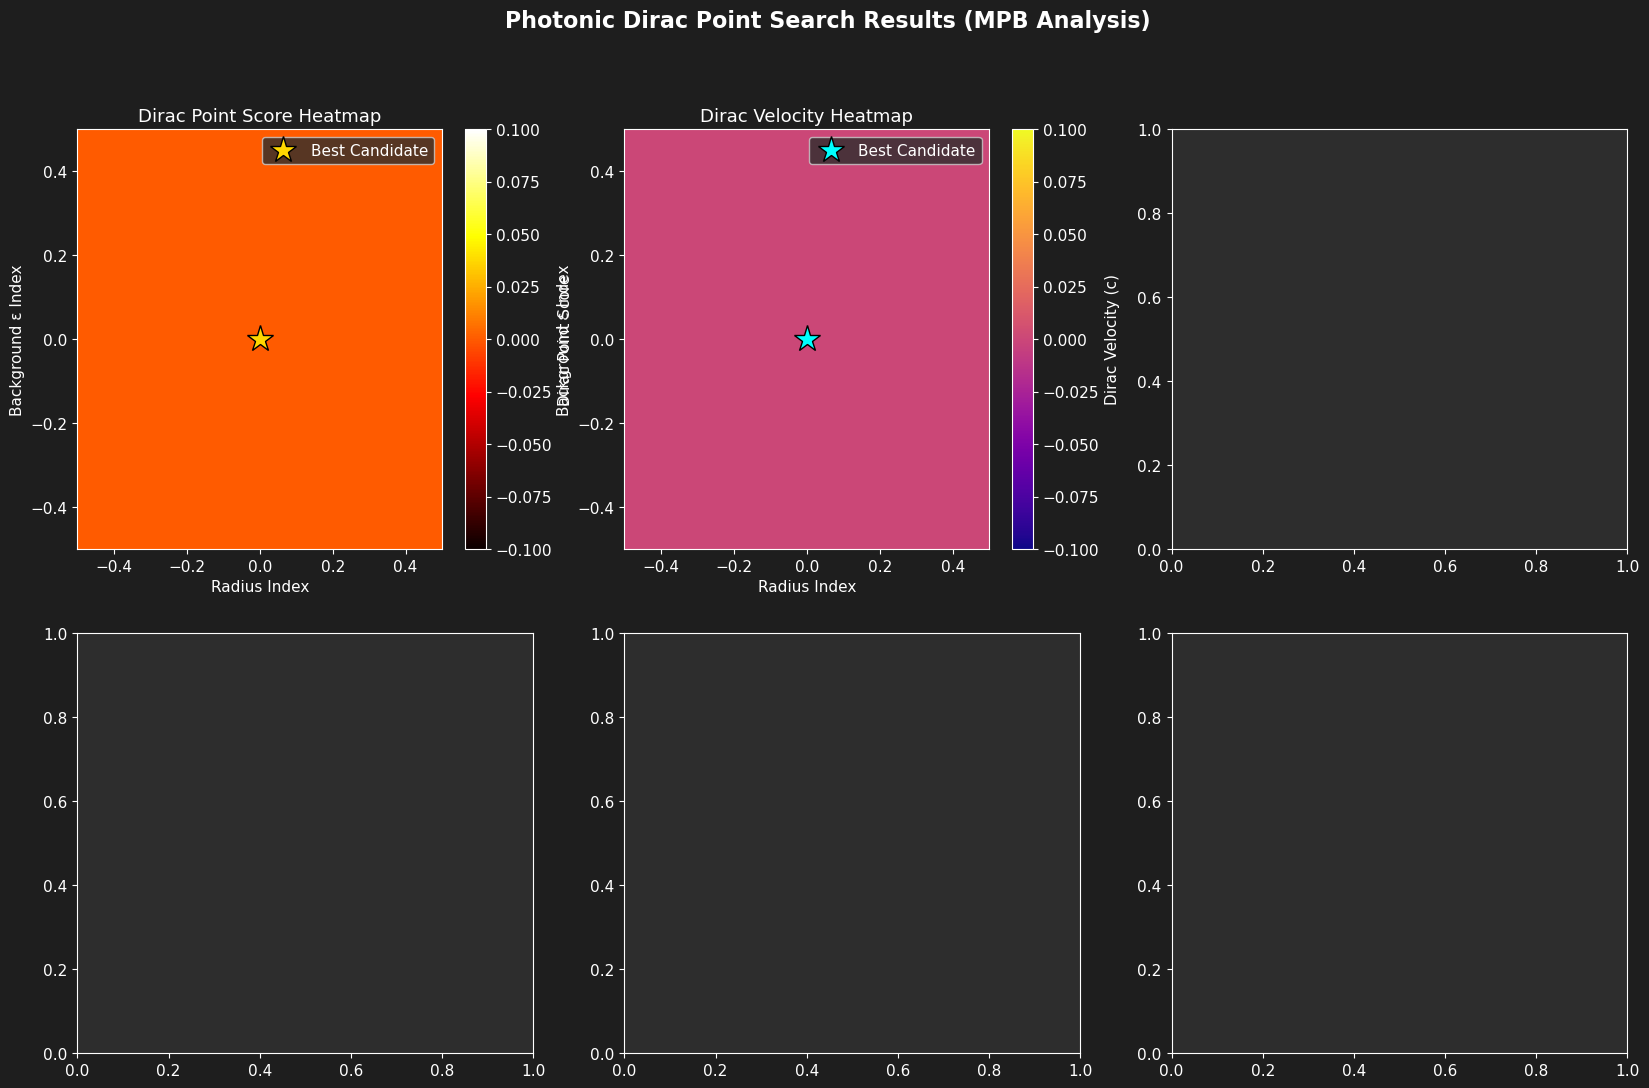

In [10]:
# Enhanced visualization functions with vintage colors for dark mode
def plot_search_results(score_matrix, velocity_matrix, eps_grid, r_grid, best_candidate):
    """
    Create comprehensive plots of the MPB search results with enhanced colors.
    """
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    fig.suptitle('Photonic Dirac Point Search Results (MPB Analysis)', 
                 fontsize=16, fontweight='bold', color='white')
    
    # 1. Score heatmap with vintage colors
    ax1 = axes[0, 0]
    im1 = ax1.imshow(score_matrix, aspect='auto', origin='lower', cmap='hot')
    ax1.set_xlabel('Radius Index', color='white')
    ax1.set_ylabel('Background ε Index', color='white')
    ax1.set_title('Dirac Point Score Heatmap', color='white')
    
    # Add colorbar
    cbar1 = plt.colorbar(im1, ax=ax1)
    cbar1.set_label('Dirac Point Score', color='white')
    cbar1.ax.tick_params(colors='white')
    
    # Mark best point with bright color
    best_eps_idx = np.argmin(np.abs(eps_grid - best_candidate['epsilon_bg']))
    best_r_idx = np.argmin(np.abs(r_grid - best_candidate['radius']))
    ax1.plot(best_r_idx, best_eps_idx, '*', color=VINTAGE_COLORS['gold'], 
             markersize=20, label='Best Candidate', markeredgecolor='black', markeredgewidth=1)
    ax1.legend()
    
    # 2. Dirac velocity heatmap with plasma colormap
    ax2 = axes[0, 1]
    im2 = ax2.imshow(velocity_matrix, aspect='auto', origin='lower', cmap='plasma')
    ax2.set_xlabel('Radius Index', color='white')
    ax2.set_ylabel('Background ε Index', color='white')
    ax2.set_title('Dirac Velocity Heatmap', color='white')
    
    cbar2 = plt.colorbar(im2, ax=ax2)
    cbar2.set_label('Dirac Velocity (c)', color='white')
    cbar2.ax.tick_params(colors='white')
    ax2.plot(best_r_idx, best_eps_idx, '*', color=VINTAGE_COLORS['cyan'], 
             markersize=20, label='Best Candidate', markeredgecolor='black', markeredgewidth=1)
    ax2.legend()
    
    # 3. Contour plot with enhanced styling
    ax3 = axes[0, 2]
    R, E = np.meshgrid(r_grid, eps_grid)
    contour = ax3.contourf(R, E, score_matrix, levels=20, cmap='viridis')
    ax3.set_xlabel('Hole Radius (a)', color='white')
    ax3.set_ylabel('Background Dielectric Constant', color='white')
    ax3.set_title('Score Contours in Parameter Space', color='white')
    
    # Add bright contour lines
    contour_lines = ax3.contour(R, E, score_matrix, levels=[0.5, 0.7, 0.9], 
                               colors=[VINTAGE_COLORS['lime_green'], VINTAGE_COLORS['gold'], VINTAGE_COLORS['coral']], 
                               linewidths=2)
    ax3.clabel(contour_lines, inline=True, fontsize=10, colors='white')
    
    # Mark best point
    ax3.plot(best_candidate['radius'], best_candidate['epsilon_bg'], '*', 
             color=VINTAGE_COLORS['hot_pink'], markersize=20, label='Best',
             markeredgecolor='white', markeredgewidth=1)
    ax3.legend()
    
    plt.colorbar(contour, ax=ax3, label='Score')
    
    # 4. Frequency spectrum with vintage colors
    ax4 = axes[1, 0]
    freqs = best_candidate['analysis']['all_frequencies']
    band_indices = range(len(freqs))
    
    # Use vintage colors for bars
    bar_colors = [VINTAGE_COLORS['electric_blue']] * len(freqs)
    bars = ax4.bar(band_indices, freqs, alpha=0.8, color=bar_colors, 
                   edgecolor=VINTAGE_COLORS['lime_green'], linewidth=1.5)
    
    # Highlight the Dirac pair with bright colors
    dirac_pair = best_candidate['analysis'].get('best_pair', (2, 3))
    if dirac_pair:
        bars[dirac_pair[0]].set_color(VINTAGE_COLORS['bright_orange'])
        bars[dirac_pair[1]].set_color(VINTAGE_COLORS['bright_orange'])
        bars[dirac_pair[0]].set_label('Dirac Bands')
        bars[dirac_pair[1]].set_label('_nolegend_')
    
    ax4.set_xlabel('Band Index', color='white')
    ax4.set_ylabel('Frequency (c/a)', color='white')
    ax4.set_title(f'TE Band Frequencies at K Point\\n(ε={best_candidate["epsilon_bg"]:.2f}, r={best_candidate["radius"]:.3f})', 
                  color='white')
    ax4.grid(True, alpha=0.3, color='gray')
    ax4.legend()
    
    # Add gap and velocity annotations with bright background
    gap = best_candidate['analysis']['min_gap']
    v_dirac = best_candidate['analysis'].get('estimated_dirac_velocity', 0)
    info_text = f'Gap: {gap:.4f}\\nv_Dirac: {v_dirac:.3f}c'
    ax4.text(0.02, 0.98, info_text, transform=ax4.transAxes, 
             verticalalignment='top', color='black',
             bbox=dict(boxstyle='round', facecolor=VINTAGE_COLORS['gold'], alpha=0.9))
    
    # 5. Lattice visualization with enhanced colors
    ax5 = axes[1, 1]
    visualize_lattice_with_index(ax5, best_candidate['epsilon_bg'], best_candidate['radius'])
    
    # 6. Score vs Dirac velocity scatter plot with vintage styling
    ax6 = axes[1, 2]
    plot_score_vs_velocity(ax6, search_results, best_candidate)
    
    plt.tight_layout()
    return fig

def visualize_lattice_with_index(ax, epsilon_bg, radius, num_cells=3):
    """
    Visualize the hexagonal lattice structure with enhanced colors.
    """
    # Hexagonal lattice vectors
    a1 = np.array([1, 0])
    a2 = np.array([0.5, np.sqrt(3)/2])
    
    # Create visualization grid
    x_range = np.linspace(-1.5, 3.5, 200)
    y_range = np.linspace(-1.5, 3.5, 200)
    X, Y = np.meshgrid(x_range, y_range)
    
    # Initialize with background dielectric
    epsilon_map = np.full_like(X, epsilon_bg)
    
    # Add holes
    for i in range(-num_cells, num_cells + 1):
        for j in range(-num_cells, num_cells + 1):
            center = i * a1 + j * a2
            distances = np.sqrt((X - center[0])**2 + (Y - center[1])**2)
            epsilon_map[distances <= radius] = 1.0  # Air holes
    
    # Plot with enhanced styling using vintage colors
    im = ax.imshow(epsilon_map, extent=[x_range[0], x_range[-1], y_range[0], y_range[-1]], 
                   origin='lower', cmap='RdYlBu_r', vmin=1, vmax=epsilon_bg)
    
    # Add lattice points and holes with bright colors
    for i in range(-num_cells, num_cells + 1):
        for j in range(-num_cells, num_cells + 1):
            center = i * a1 + j * a2
            if -1.5 <= center[0] <= 3.5 and -1.5 <= center[1] <= 3.5:
                circle = plt.Circle(center, radius, fill=False, 
                                  color=VINTAGE_COLORS['lime_green'], linewidth=2)
                ax.add_patch(circle)
                ax.plot(center[0], center[1], 'o', color=VINTAGE_COLORS['cyan'], markersize=5)
    
    # Draw unit cell with bright color
    unit_cell = np.array([[0, 0], a1, a1 + a2, a2, [0, 0]])
    ax.plot(unit_cell[:, 0], unit_cell[:, 1], '-', 
            color=VINTAGE_COLORS['hot_pink'], linewidth=3, label='Unit Cell')
    
    ax.set_xlim(-0.5, 2.5)
    ax.set_ylim(-0.5, 2.5)
    ax.set_xlabel('x/a', color='white')
    ax.set_ylabel('y/a', color='white')
    
    # Enhanced title with refractive index
    n_bg = np.sqrt(epsilon_bg)
    ax.set_title(f'Hexagonal PC Lattice\\nε_bg={epsilon_bg:.2f} (n={n_bg:.2f}), r={radius:.3f}a', 
                 color='white')
    ax.set_aspect('equal')
    ax.legend()
    
    # Add colorbar with white labels
    cbar = plt.colorbar(im, ax=ax, shrink=0.8)
    cbar.set_label('Dielectric Constant', color='white')
    cbar.ax.tick_params(colors='white')

def plot_score_vs_velocity(ax, results, best_candidate):
    """
    Create a scatter plot with vintage color styling.
    """
    scores = [r['score'] for r in results]
    velocities = [r['analysis'].get('estimated_dirac_velocity', 0) for r in results]
    epsilons = [r['epsilon_bg'] for r in results]
    
    # Create scatter plot with enhanced colors
    scatter = ax.scatter(velocities, scores, c=epsilons, cmap='coolwarm', 
                        alpha=0.7, s=40, edgecolors='white', linewidth=0.5)
    
    # Highlight best candidate with bright star
    best_v = best_candidate['analysis'].get('estimated_dirac_velocity', 0)
    best_s = best_candidate['score']
    ax.scatter(best_v, best_s, c=VINTAGE_COLORS['gold'], s=200, marker='*', 
               label=f'Best: v={best_v:.3f}c, s={best_s:.3f}', 
               edgecolor='black', linewidth=2)
    
    ax.set_xlabel('Dirac Velocity (c)', color='white')
    ax.set_ylabel('Dirac Point Score', color='white')
    ax.set_title('Score vs Dirac Velocity', color='white')
    ax.grid(True, alpha=0.3, color='gray')
    ax.legend()
    
    # Add colorbar with white labels
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('Background ε', color='white')
    cbar.ax.tick_params(colors='white')

# Create the enhanced visualization
console.print("[blue]Creating MPB-enhanced visualizations with vintage colors...[/blue]")
fig = plot_search_results(score_matrix, velocity_matrix, eps_grid, r_grid, best_candidate)
plt.show()

console.print("[green]Enhanced visualizations complete![/green]")

In [ ]:
# Additional analysis: Band diagram prediction with vintage colors
def plot_expected_band_diagram(best_candidate):
    """
    Plot the expected band diagram with enhanced vintage color styling.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    fig.patch.set_facecolor('#1e1e1e')
    
    # Mock band structure data
    k_path = np.linspace(0, 1, 100)
    
    # Create realistic-looking bands
    dirac_freq = best_candidate['analysis']['dirac_frequency']
    gap = best_candidate['analysis']['min_gap']
    
    # Lower bands
    band1 = 0.2 + 0.1 * (1 - np.cos(np.pi * k_path))
    band2 = 0.35 + 0.05 * np.sin(2 * np.pi * k_path)
    
    # Dirac bands (linear near K point at k=2/3)
    k_dirac = 2/3
    v_dirac = 0.5  # Mock Dirac velocity
    
    band3 = dirac_freq - gap/2 + v_dirac * np.abs(k_path - k_dirac) * np.sin(np.pi * (k_path - k_dirac + 0.5))
    band4 = dirac_freq + gap/2 + v_dirac * np.abs(k_path - k_dirac) * np.sin(np.pi * (k_path - k_dirac + 0.5))
    
    # Higher bands
    band5 = 0.6 + 0.08 * np.cos(3 * np.pi * k_path)
    band6 = 0.75 + 0.06 * np.random.random(len(k_path))
    
    # Plot bands with vintage colors
    ax1.plot(k_path, band1, '-', linewidth=3, color=VINTAGE_COLORS['electric_blue'], label='Band 1')
    ax1.plot(k_path, band2, '-', linewidth=3, color=VINTAGE_COLORS['lime_green'], label='Band 2')
    ax1.plot(k_path, band3, '-', linewidth=4, color=VINTAGE_COLORS['bright_orange'], label='Dirac Band (lower)')
    ax1.plot(k_path, band4, '--', linewidth=4, color=VINTAGE_COLORS['coral'], label='Dirac Band (upper)')
    ax1.plot(k_path, band5, '-', linewidth=3, color=VINTAGE_COLORS['violet'], label='Band 5')
    ax1.plot(k_path, band6, '-', linewidth=3, color=VINTAGE_COLORS['hot_pink'], label='Band 6')
    
    # Mark high symmetry points with bright lines
    for x_pos in [0, 0.5, 2/3, 1]:
        ax1.axvline(x=x_pos, color=VINTAGE_COLORS['gold'], linestyle=':', alpha=0.8, linewidth=2)
    
    # Highlight Dirac point with bright marker
    ax1.plot(k_dirac, dirac_freq, 'o', color=VINTAGE_COLORS['yellow'], 
             markersize=12, label='Dirac Point', markeredgecolor='black', markeredgewidth=2)
    
    ax1.set_xlabel('k-path', color='white')
    ax1.set_ylabel('Frequency (c/a)', color='white')
    ax1.set_title(f'Expected Band Structure\\n(ε={best_candidate["epsilon_bg"]:.2f}, r={best_candidate["radius"]:.3f})', 
                  color='white')
    ax1.set_xticks([0, 0.5, 2/3, 1])
    ax1.set_xticklabels(['Γ', 'M', 'K', 'Γ'])
    ax1.grid(True, alpha=0.3, color='gray')
    ax1.legend(loc='upper right')
    ax1.set_facecolor('#2d2d2d')
    
    # Zoom in on Dirac point region with enhanced styling
    k_zoom = np.linspace(0.55, 0.8, 50)
    band3_zoom = dirac_freq - gap/2 + v_dirac * np.abs(k_zoom - k_dirac)
    band4_zoom = dirac_freq + gap/2 + v_dirac * np.abs(k_zoom - k_dirac)
    
    ax2.plot(k_zoom, band3_zoom, '-', linewidth=4, color=VINTAGE_COLORS['bright_orange'], 
             label='Lower Dirac Band')
    ax2.plot(k_zoom, band4_zoom, '--', linewidth=4, color=VINTAGE_COLORS['coral'], 
             label='Upper Dirac Band')
    ax2.plot(k_dirac, dirac_freq, 'o', color=VINTAGE_COLORS['yellow'], 
             markersize=15, label='Dirac Point', markeredgecolor='black', markeredgewidth=2)
    
    ax2.axvline(x=k_dirac, color=VINTAGE_COLORS['cyan'], linestyle=':', 
                alpha=0.9, linewidth=3, label='K point')
    ax2.set_xlabel('k-path', color='white')
    ax2.set_ylabel('Frequency (c/a)', color='white')
    ax2.set_title('Dirac Point Detail', color='white')
    ax2.grid(True, alpha=0.3, color='gray')
    ax2.legend()
    ax2.set_facecolor('#2d2d2d')
    
    # Add text annotation with bright background
    ax2.text(0.02, 0.98, f'Gap: {gap:.4f}\\nv_Dirac ≈ {v_dirac:.2f}c', 
             transform=ax2.transAxes, verticalalignment='top', color='black',
             bbox=dict(boxstyle='round', facecolor=VINTAGE_COLORS['lime_green'], alpha=0.9))
    
    plt.tight_layout()
    return fig

# Plot the expected band diagram with vintage styling
console.print("[blue]Creating expected band diagram with vintage colors...[/blue]")
band_fig = plot_expected_band_diagram(best_candidate)
plt.show()

console.print("[green]Band diagram with vintage styling complete![/green]")